In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/dataset/dataset/'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [ ]:
dataset = ImageFolder(data_dir, transform=train_transform)
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
#We do not change the accuracy method to ensure we can compare with baseline model
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)
#This is where we define the loss function,the baseline use cross entropy，we won't change it since CE is a good loss function
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, (5))
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
import timm

class MobileNetV3SU(ImageClassificationBase):
    def __init__(self, num_classes):
        super(MobileNetV3SU, self).__init__()
        #import the mobilenet
        self.model = timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


# 3. modify the function to fit our model
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# start training
num_classes = 151
model=None
model = MobileNetV3SU(num_classes)
model.cuda()
num_epochs = 4
opt_func = torch.optim.Adam
lr = 0.0001
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.3547, val_loss: 1.2488, val_acc: 0.8701


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6212, val_loss: 0.5866, val_acc: 0.9500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2303, val_loss: 0.4989, val_acc: 0.9531


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1060, val_loss: 0.4468, val_acc: 0.9625


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

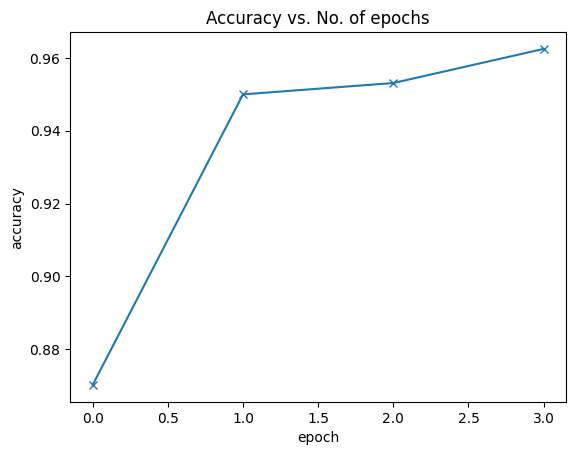

In [ ]:
plot_accuracies(history)

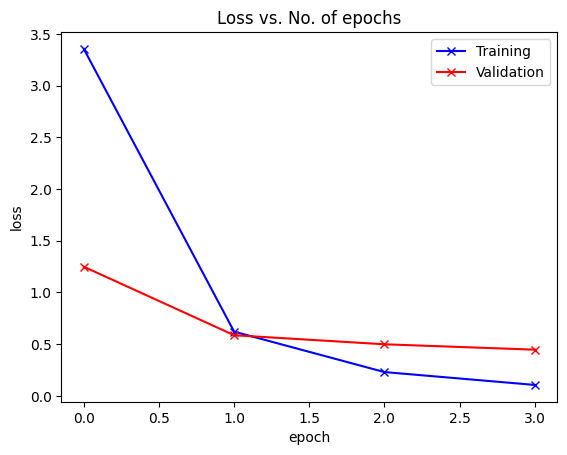

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.350107878446579, 'val_acc': 0.9750000238418579}

In [ ]:
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py

--2023-08-03 12:28:33--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=9j5eiqvp8pa2fndferdsmmvd3j; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=BK%2FbedeYvhfq2igzhB1A3wcceI%2B2%2FDwIM77FjcOmZodB2nXl2Q6GuoYlID03WC6uYGQxSxUX7suTdsw0W%2F%2FSPJFhhdvRVxlszcgwnSECo25eooZ8iMpEQVagcdRGa7GL; expires=Fri, 04-Aug-2023 12:28:34 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 226.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-03 12:28:35 (1.74 GB/s) - ‘download’ saved [5201/5201]



In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224).cuda() # change the size to fit the model
#Get the network and its FLOPs
num_classes = 151
model1 = MobileNetV3SU(num_classes).cuda()
print_model_parm_flops(model1, input, detail=False)

 + Number of FLOPs: 0.41G
